<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q d2l 

     |████████████████████████████████| 82 kB 716 kB/s 
     |████████████████████████████████| 61 kB 9.0 MB/s 
     |████████████████████████████████| 15.7 MB 61.9 MB/s 
     |████████████████████████████████| 9.9 MB 46.8 MB/s 
     |████████████████████████████████| 11.2 MB 55.8 MB/s 
     |████████████████████████████████| 930 kB 54.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [14]:
!pip install torchinfo -q

In [18]:
import os
import torch
from torch import nn
from d2l import torch as d2l
import nltk
import collections
from torchinfo import summary
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
d2l.DATA_HUB['aclImdb'] = ( 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', '01ada507287d82875905620988597833ad4e0903')
data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [4]:
def read_imdb(data_dir, is_train):
  """Read the IMDb review dataset text sequences and labels.""" 
  data, labels = [], []
  for label in ('pos', 'neg'):
    folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
    for file in os.listdir(folder_name):
      with open(os.path.join(folder_name, file), 'rb') as f:
        review = f.read().decode('utf-8').replace('\n', '') 
        data.append(review)
        labels.append(1 if label == 'pos' else 0)
  return data, labels


train_data = read_imdb(data_dir, is_train=True)

In [ ]:
train_tokens=[nltk.tokenize.word_tokenize(sentence) for sentence in train_data[0]]


In [5]:
class Vocab:
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None: 
      reserved_tokens = []
    # Sort according to frequencies
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1],reverse=True)

    #Build vocab on init
    self.idx_to_token=['<unk>']+reserved_tokens #List
    self.token_to_idx={token:idx for idx,token in enumerate(self.idx_to_token)} #Dict

    for token,freq in self._token_freqs:
      #Don't include tokens with freq<min_freq in the vocab
      if freq<min_freq:
        break
      if token not in self.idx_to_token:
        self.idx_to_token.append(token)
        self.token_to_idx[token]=len(self.idx_to_token)-1

  def __len__(self):
    return len(self.idx_to_token)

  @property
  def unk(self):
    # Index for the unknown token
    return 0
  
  @property
  def token_freqs(self):
    # Counter object 
    return self._token_freqs
  
  def __getitem__(self,tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.token_to_idx.get(tokens, self.unk) 
    #If tokens is a list 
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_token[indices]
    #If indices is a list
    return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
  """Count token frequencies."""
  # Here `tokens` is a 1D list or 2D list
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # Flatten a list of token lists into a 1D list
    tokens = [token for line in tokens for token in line]
  #If its already a 1D list,return  
  return collections.Counter(tokens)


In [ ]:
vocab = Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

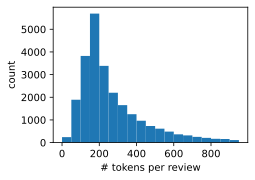

In [ ]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [6]:
def truncate_pad(line, num_steps, padding_token):
  """Truncate or pad sequences."""
  #Line is a list of tokens
  if len(line) > num_steps:
    return line[:num_steps] # Truncate
  return line + [padding_token] * (num_steps - len(line)) # Pad

In [7]:
def create_iterator(dataset,batch_size,is_train=True):
  dataset=torch.utils.data.TensorDataset(*dataset)

  return torch.utils.data.DataLoader(dataset,batch_size,shuffle=is_train)

In [ ]:
num_steps = 512 # sequence length 
train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens]) 
print(train_features.shape)

train_iter = create_iterator((train_features, torch.tensor(train_data[1])), 64)

torch.Size([25000, 512])


In [8]:
def load_data_imdb(batch_size, num_steps=512):
  """Return data iterators and the vocabulary of the IMDb review dataset.""" 
  data_dir = d2l.download_extract('aclImdb', 'aclImdb')
  train_data = read_imdb(data_dir, True)
  test_data = read_imdb(data_dir, False)

  train_tokens = [nltk.tokenize.word_tokenize(sentence) for sentence in train_data[0]]
  test_tokens =  [nltk.tokenize.word_tokenize(sentence) for sentence in test_data[0]]

  vocab = Vocab(train_tokens, min_freq=5)

  train_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in train_tokens]) 
  test_features = torch.tensor([truncate_pad(vocab[line], num_steps, vocab['<pad>']) for line in test_tokens]) 

  train_iter = create_iterator((train_features, torch.tensor(train_data[1])),batch_size)
  test_iter = create_iterator((test_features, torch.tensor(test_data[1])),batch_size,is_train=False) 
  
  return train_iter, test_iter, vocab

#Building the BiLSTM

In [9]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In the following BiRNN class, while each token of a text sequence gets its individual pretrained GloVe representation via the embedding layer (self. embedding), the entire sequence is encoded by a bidirectional RNN (self.encoder). 

More concretely, the hidden states (at the last layer) of the bidirectional LSTM at both the initial and final time steps are concatenated as the representation of the text sequence.

This single text representation is then transformed into output categories by a fully-connected layer (self.decoder) with two outputs (“positive” and “negative”).

In [10]:
class BiRNN(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens,num_layers, **kwargs):
    super(BiRNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    #batch_first= True indicates batch_size,max_len,embed_size

    self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,batch_first=True,bidirectional=True)
    self.decoder = nn.Linear(2 * num_hiddens, 2)
  
  def forward(self, inputs):
    #inputs-> batch_size,num_steps

    embeddings = self.embedding(inputs)

    #We do this beacause RNNs in PyTorch do not allocate contigious memory
    # we make this call to make sure that the weights are stored contiigiously
    #to reduce overhead
    self.encoder.flatten_parameters()

    outputs, _ = self.encoder(embeddings)
    #Discard cell states and hidden states here
    #Outputs are of shape -> batch_size,seq_len,2*num_hiddens

    encoding = torch.mean(outputs,dim=1) #batch_size,2*num_hiddens
    outs = self.decoder(encoding)
    return outs




In [11]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight) 
  if type(m) == nn.LSTM:
    for param in m._flat_weights_names: 
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param]) 



In [12]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus() 
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights);

In [20]:
summary(net, (batch_size, 512),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
BiRNN                                    [64, 2]                   --
├─Embedding: 1-1                         [64, 512, 100]            3,581,300
├─LSTM: 1-2                              [64, 512, 200]            403,200
├─Linear: 1-3                            [64, 2]                   402
Total params: 3,984,902
Trainable params: 3,984,902
Non-trainable params: 0
Total mult-adds (G): 13.44
Input size (MB): 0.26
Forward/backward pass size (MB): 78.64
Params size (MB): 15.94
Estimated Total Size (MB): 94.85

In [21]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [22]:
embeds = glove_embedding[vocab.idx_to_token] 
embeds.shape

torch.Size([35813, 100])

In [23]:
#Set embeddings
net.embedding.weight.data.copy_(embeds) 
net.embedding.weight.requires_grad = False

In [24]:
summary(net, (batch_size, 512),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
BiRNN                                    [64, 2]                   --
├─Embedding: 1-1                         [64, 512, 100]            (3,581,300)
├─LSTM: 1-2                              [64, 512, 200]            403,200
├─Linear: 1-3                            [64, 2]                   402
Total params: 3,984,902
Trainable params: 403,602
Non-trainable params: 3,581,300
Total mult-adds (G): 13.44
Input size (MB): 0.26
Forward/backward pass size (MB): 78.64
Params size (MB): 15.94
Estimated Total Size (MB): 94.85

**By using pretrained embeddings we managed to reduce the size of the model from 3.9 million params to 400k params**

In [ ]:
lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode 
    if not device:
      device = next(iter(net.parameters())).device 

  # No. of correct predictions, no. of predictions 
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      X = X.to(device)
      y = y.to(device) 
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]


In [ ]:
def train_batch(net,X,y,loss,optimizer,devices):
  X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  optimizer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  optimizer.step()
  train_loss_sum = l.sum() 
  train_acc_sum = d2l.accuracy(pred, y) 
  return train_loss_sum, train_acc_sum

In [ ]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples, no. of predictions
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l,acc=train_batch(net,features,labels,loss,trainer,devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'epoch {epoch+1}: loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}') 
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

In [ ]:
# ~5 mins
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.480, train acc 0.760, test acc 0.838
epoch 2: loss 0.318, train acc 0.873, test acc 0.884
epoch 3: loss 0.258, train acc 0.899, test acc 0.891
epoch 4: loss 0.231, train acc 0.909, test acc 0.881
epoch 5: loss 0.201, train acc 0.923, test acc 0.674
epoch 6: loss 0.214, train acc 0.914, test acc 0.867
epoch 7: loss 0.200, train acc 0.921, test acc 0.889
epoch 8: loss 0.166, train acc 0.936, test acc 0.888
epoch 9: loss 0.147, train acc 0.944, test acc 0.883
epoch 10: loss 0.128, train acc 0.951, test acc 0.881
970.0 examples/sec on [device(type='cuda', index=0)]


# Predicting

In [ ]:
def predict_sentiment(net, vocab, sequence):
  """Predict the sentiment of a text sequence."""
  sequence = torch.tensor(vocab[nltk.tokenize.word_tokenize(sequence)], device=d2l.try_gpu())[None,:]
  label = torch.argmax(net(sequence), dim=1)
  return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

#Refactoring code to use Optuna for Hyperparameter Tuning

Do not run this section unless you have powerful GPUs

(Atleast a P100)

In [ ]:
!pip install optuna -q

     |████████████████████████████████| 308 kB 29.4 MB/s 
     |████████████████████████████████| 81 kB 10.4 MB/s 
     |████████████████████████████████| 209 kB 80.5 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 146 kB 80.0 MB/s 
     |████████████████████████████████| 112 kB 74.7 MB/s 


In [ ]:
def get_net(params):
  #net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
  net = BiRNN(params['vocab_size'], params['embed_size'], params['num_hiddens'], params['num_layers'])
  net.apply(init_weights);
  embeds = glove_embedding[vocab.idx_to_token]
  net.embedding.weight.data.copy_(embeds) 
  net.embedding.weight.requires_grad = False 
  return net 

In [ ]:
def train_optuna(params,net, train_iter, test_iter, loss, num_epochs, devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  trainer = getattr(optim, params['trainer'])(net.parameters(), lr= 0.01)
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples, no. of predictions
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l,acc=train_batch(net,features,labels,loss,trainer,devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
    test_acc = evaluate_accuracy_gpu(net, test_iter)
  return test_acc


In [ ]:
import optuna
import torch.optim as optim

def objective(trial):
  batch_size=64
  num_epochs = 5
  devices = d2l.try_all_gpus()
  #Ideally you'd want to create new iterators for every trial
  #However in the interest of time I'll just use the global 
  #iterators and vocab
  #train_iter, test_iter, vocab = load_data_imdb(batch_size)

  params = {
            'vocab_size' : len(vocab),
            'embed_size' : 100,
            'num_hiddens': trial.suggest_categorical("num_hiddens", [100, 256, 512]),
            'trainer': trial.suggest_categorical("trainer", ["Adam", "RMSprop", "SGD"]),
            'num_layers': trial.suggest_int("num_layers", 2, 5)
            }


  model = get_net(params)
  loss = nn.CrossEntropyLoss(reduction="none")

  test_accuracy = train_optuna(params,model,train_iter,test_iter,loss,num_epochs,devices)

  return test_accuracy


In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

In [ ]:
study.keys()

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_intermediate_values(study)


In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
optuna.visualization.plot_param_importances(study)


#1-D CNNs for Text

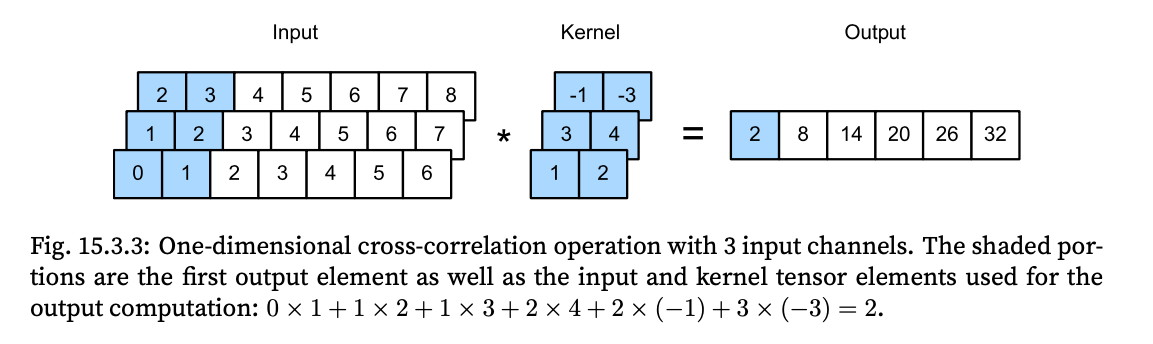

Simply put, just think of any text sequence as a one-dimensional image. In this way, one-dimensional CNNs can process local features such as n-grams in text.

For any one-dimensional input with multiple channels, the convolution kernel needs to have the same number of input channels. Then for each channel, perform a cross-correlation operation on the one-dimensional tensor of the input and the one-dimensional tensor of the convolution kernel, summing the results over all the channels to produce the one-dimensional output tensor. Fig. 15.3.3 shows a one-dimensional cross-correlation operation with 3 input channels.

In [ ]:
def corr1d(X, K): 
  w = K.shape[0]
  Y = torch.zeros((X.shape[0] - w + 1)) 
  for i in range(Y.shape[0]):
    Y[i] = (X[i: i + w] * K).sum() 
  return Y

def corr1d_multi_in(X, K):
  # First, iterate through the 0th dimension (channel dimension) of `X` and 
  # `K`. Then, add them together
  return sum(corr1d(x, k) for x, k in zip(X, K))

X =torch.tensor([[0, 1, 2, 3, 4, 5, 6],
                 [1, 2, 3, 4, 5, 6, 7],
                 [2, 3, 4, 5, 6, 7, 8]]) 

K= torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

## 1-D CNN Model
Similarly, we can use pooling to extract the highest value from sequence representations as the most important feature across time steps. The max-over-time pooling used in textCNN works like the one-dimensional global maximum pooling (Collobert et al., 2011). 

For a multi-channel input where each channel stores values at different time steps, the output at each channel is the maximum value for that channel. 

**Note that the max-over-time pooling allows different numbers of time steps at different channels.**

For a single text sequence with n tokens represented by d-dimensional vectors, the width, height, and number of channels of the input tensor are n, 1, and d, respectively. The textCNN model transforms the input into the output as follows:

1. Define multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local fea- tures among different numbers of adjacent tokens.

2. Perform max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.

3. Transform the concatenated vector into the output categories using the fully-connected layer. Dropout can be used for reducing overfitting.

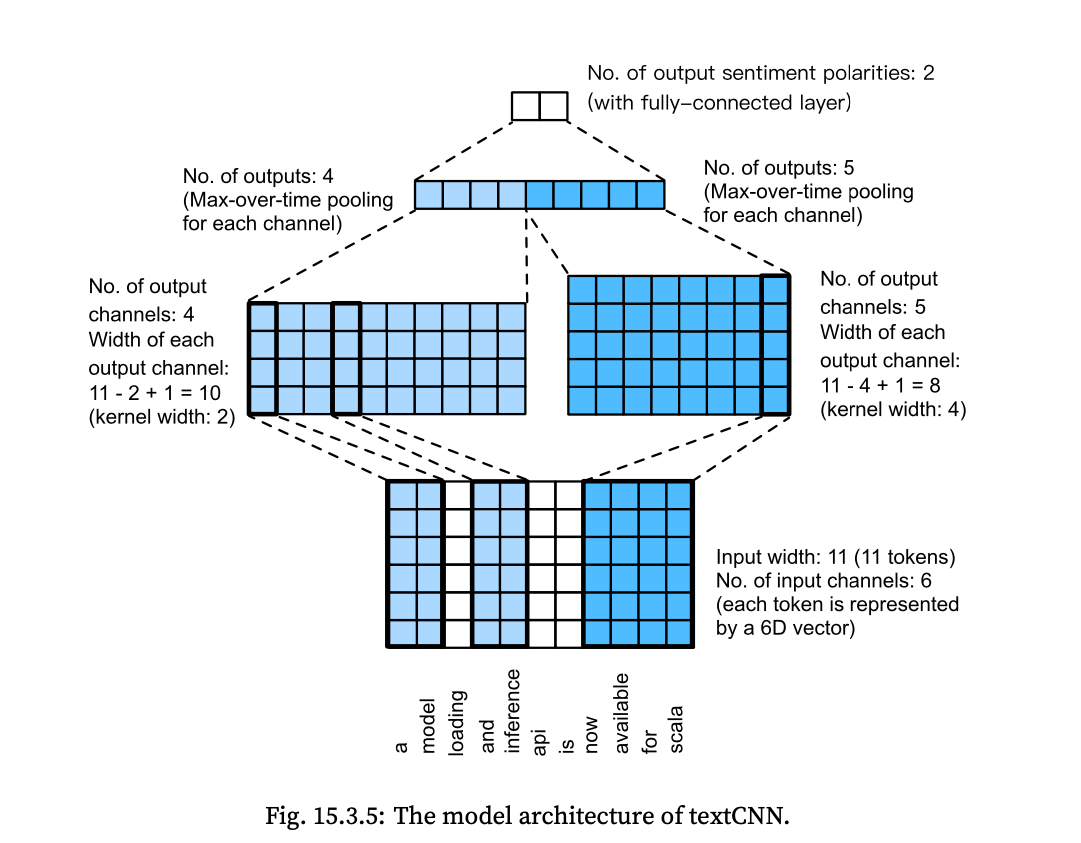

In [25]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,**kwargs):
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    # The embedding layer not to be trained
    self.constant_embedding = nn.Embedding(vocab_size, embed_size) 
    self.dropout = nn.Dropout(0.5)
    self.decoder = nn.Linear(sum(num_channels), 2)
    # The max-over-time pooling layer has no parameters, so this instance
    # can be shared
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()

    # Create multiple one-dimensional convolutional layers
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
      #in channels,out channels, kerenel width
      self.convs.append(nn.Conv1d(2 * embed_size, c, k))


  def forward(self, inputs):
    #inputs -> batch_size, max_len
    # Concatenate two embedding layer outputs with shape 
    #(batch size, max_len, token vector dimension) along vectors

    embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
    #batch_size,in_channels= 2*embedding_dims, width= max_len
    embeddings = embeddings.permute(0, 2, 1)

    #after pooling we get batch_size,out_channels_i,1 and squeeze the last dim
    #after cat we get batch_size, sum (out_channels_i) i.e sum(num_channels)
    encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) 
                          for conv in self.convs], dim=1)
    
    outputs = self.decoder(self.dropout(encoding)) 
    return outputs
    



In [26]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [50, 100, 150] 
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight) 

net.apply(init_weights)

TextCNN(
  (embedding): Embedding(35813, 100)
  (constant_embedding): Embedding(35813, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 150, kernel_size=(5,), stride=(1,))
  )
)

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')


In [27]:
#Make one set trainable 
embeds = glove_embedding[vocab.idx_to_token] 
net.embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.requires_grad = False

In [29]:
summary(net, (batch_size, 512),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [64, 2]                   --
├─Embedding: 1-1                         [64, 512, 100]            3,581,300
├─Embedding: 1-2                         [64, 512, 100]            (3,581,300)
├─ModuleList: 1-5                        --                        260,300
│    └─Conv1d: 2-1                       [64, 50, 510]             30,050
├─AdaptiveAvgPool1d: 1-3                 [64, 50, 1]               --
├─ReLU: 1-4                              [64, 50, 1]               --
├─ModuleList: 1-5                        --                        260,300
│    └─Conv1d: 2-2                       [64, 100, 509]            80,100
├─ModuleList: 1-5                        --                        260,300
├─AdaptiveAvgPool1d: 1-6                 [64, 100, 1]              --
├─ReLU: 1-7                              [64, 100, 1]              --
├─ModuleList: 1-5                        --   

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval() # Set the model to evaluation mode 
    if not device:
      device = next(iter(net.parameters())).device 

  # No. of correct predictions, no. of predictions 
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      X = X.to(device)
      y = y.to(device) 
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]


def train_batch(net,X,y,loss,optimizer,devices):
  X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  optimizer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  optimizer.step()
  train_loss_sum = l.sum() 
  train_acc_sum = d2l.accuracy(pred, y) 
  return train_loss_sum, train_acc_sum

def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples, no. of predictions
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l,acc=train_batch(net,features,labels,loss,trainer,devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'epoch {epoch+1}: loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}') 
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

def predict_sentiment(net, vocab, sequence):
  """Predict the sentiment of a text sequence."""
  sequence = torch.tensor(vocab[nltk.tokenize.word_tokenize(sequence)], device=d2l.try_gpu())[None,:]
  label = torch.argmax(net(sequence), dim=1)
  return 'positive' if label == 1 else 'negative'

In [ ]:
# 3 mins to run
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.518, train acc 0.750, test acc 0.848
epoch 2: loss 0.294, train acc 0.882, test acc 0.871
epoch 3: loss 0.208, train acc 0.920, test acc 0.881
epoch 4: loss 0.154, train acc 0.943, test acc 0.879
epoch 5: loss 0.113, train acc 0.960, test acc 0.879
epoch 6: loss 0.077, train acc 0.975, test acc 0.867
epoch 7: loss 0.061, train acc 0.980, test acc 0.863
epoch 8: loss 0.042, train acc 0.986, test acc 0.866
epoch 9: loss 0.031, train acc 0.990, test acc 0.864
epoch 10: loss 0.026, train acc 0.992, test acc 0.851
2445.1 examples/sec on [device(type='cuda', index=0)]


## Variations

### Remove learnable embedding

In [30]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,**kwargs):
    super(TextCNN, self).__init__(**kwargs)
    # The embedding layer not to be trained
    self.constant_embedding = nn.Embedding(vocab_size, embed_size) 
    self.dropout = nn.Dropout(0.5)
    self.decoder = nn.Linear(sum(num_channels), 2)
    # The max-over-time pooling layer has no parameters, so this instance
    # can be shared
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()

    # Create multiple one-dimensional convolutional layers
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
      #in channels,out channels, kerenel width
      self.convs.append(nn.Conv1d(embed_size, c, k))


  def forward(self, inputs):
    #inputs -> batch_size, max_len
    # Concatenate two embedding layer outputs with shape 
    #(batch size, max_len, token vector dimension) along vectors

    embeddings = self.constant_embedding(inputs)
    #batch_size,in_channels= embedding_dims, width= max_len
    embeddings = embeddings.permute(0, 2, 1)

    #after pooling we get batch_size,out_channels_i,1 and squeeze the last dim
    #after cat we get batch_size, sum (out_channels_i) i.e sum(num_channels)
    encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) 
                          for conv in self.convs], dim=1)
    
    outputs = self.decoder(self.dropout(encoding)) 
    return outputs
    



In [31]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [50, 100, 150] 
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight) 

net.apply(init_weights)

TextCNN(
  (constant_embedding): Embedding(35813, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 150, kernel_size=(5,), stride=(1,))
  )
)

In [32]:
#Make one set trainable 
embeds = glove_embedding[vocab.idx_to_token] 
net.constant_embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.requires_grad = False
summary(net, (batch_size, 512),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [64, 2]                   --
├─Embedding: 1-1                         [64, 512, 100]            (3,581,300)
├─ModuleList: 1-4                        --                        130,300
│    └─Conv1d: 2-1                       [64, 50, 510]             15,050
├─AdaptiveAvgPool1d: 1-2                 [64, 50, 1]               --
├─ReLU: 1-3                              [64, 50, 1]               --
├─ModuleList: 1-4                        --                        130,300
│    └─Conv1d: 2-2                       [64, 100, 509]            40,100
├─ModuleList: 1-4                        --                        130,300
├─AdaptiveAvgPool1d: 1-5                 [64, 100, 1]              --
├─ReLU: 1-6                              [64, 100, 1]              --
├─ModuleList: 1-4                        --                        130,300
│    └─Conv1d: 2-3                       [64, 15

In [ ]:
trainer = torch.optim.Adam(net.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss(reduction="none")
num_epochs = 10
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.615, train acc 0.672, test acc 0.717
epoch 2: loss 0.534, train acc 0.748, test acc 0.764
epoch 3: loss 0.511, train acc 0.758, test acc 0.768
epoch 4: loss 0.494, train acc 0.768, test acc 0.760
epoch 5: loss 0.486, train acc 0.770, test acc 0.775
epoch 6: loss 0.486, train acc 0.769, test acc 0.774
epoch 7: loss 0.478, train acc 0.772, test acc 0.768
epoch 8: loss 0.473, train acc 0.773, test acc 0.773
epoch 9: loss 0.473, train acc 0.774, test acc 0.780
epoch 10: loss 0.475, train acc 0.772, test acc 0.775
6197.2 examples/sec on [device(type='cuda', index=0)]


### Add positional encodings

#### Add sinusoidal encodings 

Based on the original transformer paper

In [33]:
class PositionalEncoding(nn.Module):
  def __init__(self, num_hiddens, dropout, max_len=512):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.P = torch.zeros((1, max_len, num_hiddens))

    # Reshape max_len to max_len X 1, hence rows signify each position in the sequence
    #Columns of X and P must go upto num_hiddens, here starting from 0 we go upto num_hiddens skipping 2
    #X-> batch_size,num_hiddens
    X=torch.arange(max_len, dtype=torch.float32).reshape(-1,1)/ torch.pow(10000,torch.arange(0,num_hiddens,2,dtype=torch.float)/num_hiddens)
    self.P[:, :, 0::2] = torch.sin(X) 
    self.P[:, :, 1::2] = torch.cos(X)

  def forward(self, X):
    #X->batch_size,max_len,num_hiddens
    X = X + self.P[:, :X.shape[1], :].to(X.device) #Take p only upto max_len
    return self.dropout(X)


In [34]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,**kwargs):
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    # The embedding layer not to be trained
    self.constant_embedding = nn.Embedding(vocab_size, embed_size) 
    self.positional_encoding = PositionalEncoding(embed_size, 0.2)
    self.dropout = nn.Dropout(0.5)
    self.decoder = nn.Linear(sum(num_channels), 2)
    # The max-over-time pooling layer has no parameters, so this instance
    # can be shared
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()

    # Create multiple one-dimensional convolutional layers
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
      #in channels,out channels, kerenel width
      self.convs.append(nn.Conv1d(2 * embed_size, c, k))


  def forward(self, inputs):
    #inputs -> batch_size, max_len
    # Concatenate two embedding layer outputs with shape 
    #(batch size, max_len, token vector dimension) along vectors

    embeddings = torch.cat((self.positional_encoding(self.embedding(inputs)),
                            self.positional_encoding(self.constant_embedding(inputs))), dim=2)
    #batch_size,  max_len, 2*embedding_dims


    embeddings = embeddings.permute(0, 2, 1)


    #after pooling we get batch_size,out_channels_i,1 and squeeze the last dim
    #after cat we get batch_size, sum (out_channels_i) i.e sum(num_channels)
    encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) 
                          for conv in self.convs], dim=1)
    
    outputs = self.decoder(self.dropout(encoding)) 
    return outputs
    



In [35]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [50, 100, 150] 
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight) 

net.apply(init_weights)

#Make one set trainable 
embeds = glove_embedding[vocab.idx_to_token] 
net.embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.requires_grad = False

summary(net, (batch_size, 512),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [64, 2]                   3,351,050
├─Embedding: 1-2                         [64, 512, 100]            (recursive)
├─Embedding: 1-2                         [64, 512, 100]            (recursive)
├─PositionalEncoding: 1-3                [64, 512, 100]            --
│    └─Dropout: 2-1                      [64, 512, 100]            --
├─Embedding: 1-4                         [64, 512, 100]            (3,581,300)
├─PositionalEncoding: 1-5                [64, 512, 100]            --
│    └─Dropout: 2-2                      [64, 512, 100]            --
├─ModuleList: 1-6                        --                        260,300
│    └─Conv1d: 2-3                       [64, 50, 510]             30,050
├─ModuleList: 1-6                        --                        260,300
├─AdaptiveAvgPool1d: 1-7                 [64, 50, 1]               --
├─ReLU: 1-8                          

In [ ]:
batch_size = 64
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.644, train acc 0.625, test acc 0.723
epoch 2: loss 0.442, train acc 0.800, test acc 0.826
epoch 3: loss 0.321, train acc 0.867, test acc 0.849
epoch 4: loss 0.281, train acc 0.889, test acc 0.881
epoch 5: loss 0.240, train acc 0.906, test acc 0.871
epoch 6: loss 0.210, train acc 0.920, test acc 0.878
epoch 7: loss 0.193, train acc 0.928, test acc 0.864
epoch 8: loss 0.171, train acc 0.937, test acc 0.886
epoch 9: loss 0.157, train acc 0.944, test acc 0.859
epoch 10: loss 0.137, train acc 0.950, test acc 0.882
2401.9 examples/sec on [device(type='cuda', index=0)]


#### Add learnable position embeddings

Based on the BERT paper

In [36]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,**kwargs):
    super(TextCNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    # The embedding layer not to be trained
    self.constant_embedding = nn.Embedding(vocab_size, embed_size) 
    #Learnable position embeddings
    self.pos_embedding = nn.Parameter(torch.randn(1, 512,embed_size))

    self.dropout = nn.Dropout(0.5)
    self.decoder = nn.Linear(sum(num_channels), 2)
    # The max-over-time pooling layer has no parameters, so this instance
    # can be shared
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()

    # Create multiple one-dimensional convolutional layers
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
      #in channels,out channels, kerenel width
      self.convs.append(nn.Conv1d(2 * embed_size, c, k))


  def forward(self, inputs):
    #inputs -> batch_size, max_len
    # Concatenate two embedding layer outputs with shape 
    #(batch size, max_len, token vector dimension) along vectors

    embeddings = torch.cat(((self.embedding(inputs) + self.pos_embedding.data[:, :inputs.shape[1], :]),
                            (self.constant_embedding(inputs) + self.pos_embedding.data[:, :inputs.shape[1], :])), dim=2)

    #batch_size, max_len, 2*embedding_dims (in_channels)



    embeddings = embeddings.permute(0, 2, 1)


    #after pooling we get batch_size,out_channels_i,1 and squeeze the last dim
    #after cat we get batch_size, sum (out_channels_i) i.e sum(num_channels)
    encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) 
                          for conv in self.convs], dim=1)
    
    outputs = self.decoder(self.dropout(encoding)) 
    return outputs
    



In [37]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [50, 100, 150] 
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv1d):
    nn.init.xavier_uniform_(m.weight) 

net.apply(init_weights)

#Make one set trainable 
embeds = glove_embedding[vocab.idx_to_token] 
net.embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.requires_grad = False

summary(net, (batch_size, 512),dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [64, 2]                   --
├─Embedding: 1-1                         [64, 512, 100]            3,581,300
├─Embedding: 1-2                         [64, 512, 100]            (3,581,300)
├─ModuleList: 1-5                        --                        260,300
│    └─Conv1d: 2-1                       [64, 50, 510]             30,050
├─AdaptiveAvgPool1d: 1-3                 [64, 50, 1]               --
├─ReLU: 1-4                              [64, 50, 1]               --
├─ModuleList: 1-5                        --                        260,300
│    └─Conv1d: 2-2                       [64, 100, 509]            80,100
├─ModuleList: 1-5                        --                        260,300
├─AdaptiveAvgPool1d: 1-6                 [64, 100, 1]              --
├─ReLU: 1-7                              [64, 100, 1]              --
├─ModuleList: 1-5                        --   

In [ ]:
# ~ 2 mins
batch_size = 64
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

epoch 1: loss 0.525, train acc 0.736, test acc 0.837
epoch 2: loss 0.302, train acc 0.876, test acc 0.877
epoch 3: loss 0.214, train acc 0.916, test acc 0.882
epoch 4: loss 0.163, train acc 0.939, test acc 0.886
epoch 5: loss 0.115, train acc 0.957, test acc 0.881
epoch 6: loss 0.084, train acc 0.972, test acc 0.878
epoch 7: loss 0.062, train acc 0.980, test acc 0.872
epoch 8: loss 0.048, train acc 0.984, test acc 0.872
epoch 9: loss 0.031, train acc 0.991, test acc 0.868
epoch 10: loss 0.024, train acc 0.993, test acc 0.867
2389.8 examples/sec on [device(type='cuda', index=0)]
